In [46]:
import serial
import struct
import time
import numpy as np
from serial.tools.list_ports import comports

def read_number(msg):
    while True:
        try:
            #return 2;
            return int(input(msg))
        except: print("ERROR: Not a number")

def read_port(msg):
    while True:
        try:
            port = input(msg)
            #index = input(msg)
            #port = "COM8";
            return serial.Serial(port, 9600)
        except: print(f"ERROR: Wrong port connection")
            
def print_until_keyword(keyword, device):
    while True: 
        msg = device.serial.readline().decode()
        if msg[:-2] == keyword: break
        #else: print(f'({arduino.port}):',msg, end='')
            
def read_matrix(device, dimms):
    result = np.zeros((1,dimms)).reshape(-1)
    for i in range(dimms):
        device.serial.read()
        result[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return result.reshape(dimms)


In [47]:
class Device:
    def __init__(self, serial):
        self.serial = serial
        self.weights = []
        self.metalayers = []
        
    def set_weights(self, weights):
        self.weights = weight
        
    def set_metadata(self, metalayer):
        self.metalayer = metalayer
        
def getDevices():
    num_devices = read_number("Number of devices: ")
    # num_devices = 2

    available_ports = comports()
    print("Available ports:")
    for available_port in available_ports: print(available_port)

    devices = [read_port(f"Port device_{i+1}: ") for i in range(num_devices)]
    list_devices = []
    for device in devices:
        list_devices.append(Device(device))
    return list_devices

class Layer:
    def __init__(self, layer_type):
        self.layer_type = layer_type
        
    def __repr__(self):
        return f"{self.layer_type}"
    
class Dense(Layer):
    def __init__(self, rows, cols):
        super().__init__("Dense")
        self.rows = rows
        self.cols = cols
        
    def __repr__(self):
        return f"{self.layer_type=} {self.rows=} {self.cols=}"
    
class MaxPooling(Layer):
    def __init__(self):
        super().__init__("MaxPooling")
        
    def __repr__(self):
        return f"{self.layer_type}"
    
class Conv2D(Layer):
    def __init__(self, kh, kw, c, kc):
        super().__init__("Conv2D")
        self.kh = kh
        self.kw = kw
        self.c = c
        self.kc = kc
        
    def __repr__(self):
        return f"{self.layer_type=} - {self.kh=} {self.kw=} {self.c=} {self.kc=}"
        

In [48]:
# Send the blank model to all the devices
def receive_model_info(device):
    device.serial.reset_input_buffer()
    device.serial.write(b's') # Python --> ACK --> Arduino
    print_until_keyword('start', device) # CLEAN SERIAL
    
    bytesToRead = device.serial.read(1).decode()
    time.sleep(1)
    if bytesToRead == 'i':
        [num_layers] = struct.unpack('i', device.serial.read(4))
        layers = []
        for i in range(num_layers):
            [layer_type] = struct.unpack('i', device.serial.read(4))
            if layer_type == -1:
                [rows, cols] = struct.unpack('ii', device.serial.read(8))
                layers.append(Dense(rows, cols))
            elif layer_type == -2:
                layers.append(MaxPooling())
            elif layer_type == -3:
                [kh, kw, c, kc] = struct.unpack('iiii', device.serial.read(16))
                layers.append(Conv2D(kh,kw,c,kc))
            # dimms.append((1,cols)) # bias
            # dimms.append((rows,cols)) # matrix weigths
    return num_layers, layers


In [49]:
def initialize_device_weights(device, bias_dimm, w_dimm):
    bias = np.zeros(bias_dimm)
    weights = np.random.randn(w_dimm[0], w_dimm[1]) * np.sqrt(6.0 / (w_dimm[0] + w_dimm[1]))
    device.serial.write(struct.pack('f'*len(bias.reshape(-1)), *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f'*len(weights.reshape(-1)), *weights.reshape(-1)))
    
def initialize_device_weights_cnn(device, kh, kw, c, kc):
    bias = np.zeros((1,kc))
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.random.randn(kh, kw, c, kc) * np.sqrt(6.0 / (in_size + out_size))
    print(f"Sending weights for layer Conv2D")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
    device.serial.write(struct.pack('f'*len(bias.reshape(-1)), *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f'*len(weights.reshape(-1)), *weights.reshape(-1)))
    
## RECEIVE MODEL WEIGHT
def get_device_weights(device, bias_dimm, w_dimm):
    number_of_floats = w_dimm[0] * w_dimm[1]
    weights = np.zeros(w_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
        
    number_of_floats = bias_dimm[0] * bias_dimm[1]
    bias = np.zeros(bias_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape(w_dimm), bias.reshape(bias_dimm)
    
def get_device_weights_cnn(device, kh, kw, c, kc):
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.random.randn(kh, kw, c, kc) * np.sqrt(6.0 / (in_size + out_size)).reshape(-1)
    for w in weights.reshape(-1):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
    
    bias = np.zeros((1,kc)).reshape(-1)
    for b in bias.reshape(-1):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]

    return weights.reshape((kh, kw, c, kc)), bias.reshape((1,kc))
    

In [50]:
def send_initial_weights(device):
    num_layers, layers = receive_model_info(device)
    device.metalayers = layers
    for layer in layers:
        if layer.layer_type == "Conv2D":
            initialize_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
        elif layer.layer_type == "Dense":
            initialize_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
    print(f"{device.serial.port} weights initialized!")

In [51]:
def send_weights(device, weights):
    weights = weights[0]
    bias = weights[1]
    #print(f"Sending bias for Dense {bias.reshape(-1).shape} {device.serial.port}")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
        #device.serial.write(struct.pack('f', b))
    device.serial.write(struct.pack('f'*len(bias.reshape(-1)),*bias.reshape(-1)))
        
    #print(f"Sending weights for Dense {weights.reshape(-1).shape} {device.serial.port}")
    #for w in weights.reshape(-1):
        #data = device.serial.read()
    device.serial.write(struct.pack('f'*len(weights.reshape(-1)), *weights.reshape(-1)))
        
def send_model_weights(device, weights):
    layers = device.metalayers
    device.serial.write(b'r')
    for i, layer in enumerate(layers):
        assert weights[i][0].shape == device.weights[i][0].shape and \
        weights[i][1].shape == device.weights[i][1].shape , \
        f"{weights[i][0].shape}!={device.weights[i][0].shape}, \
        {weights[i][1].shape}!={device.weights[i][1].shape}"
        
        send_weights(device, weights[i])
    #print(f"{device.serial.port} weights initialized!")

In [52]:
def get_model_weights(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.weights = []
    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.weights.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.weights.append((weights, biases))
    #print(f"Model weight received!")


In [53]:
def send_sample(device, X, y=None):
    if IS_KEYWORD_SPOTTING:
        device.serial.write(struct.pack('h' * len(X), *X.reshape(-1)))
    else:
        device.serial.write(struct.pack('f' * len(X), *X.reshape(-1)))

    if y is not None:
        for t in y.reshape(-1):
            data = device.serial.read()
            device.serial.write(struct.pack('f', t))

def get_tick():
    return time.time_ns()

def train(device, X, y, size=1):
    error = 0.0
    for i in range(size):
        #print(f"Sending element {i}/{size}")
        device.serial.write(b"t")
        send_sample(device, X[i], y[i].reshape(1,TARGET_SIZE))
        #print("SAMPLE SENT")

        start = get_tick()
        n_error = device.serial.read(4)
        #print(f"returned error = {n_error}")
        end = get_tick()
        loss = struct.unpack('f', n_error)[0]
        error += loss
    return end-start, error/size

def predict(device, X, y):
    device.serial.write(b"p")
    send_sample(device, X, y.reshape(1,TARGET_SIZE))
    #print("SAMPLE SENT")
    # read last layer size output
    # Target size + 1 for the loss value
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    return get_tick() - start, output[:-1], output[-1]


- call getDevices() to obtain all conected devices
- asks the user how many devices you want to use
- send the initial model for every device
- create thread for every device
    - send samples and start training for one epoch
- wait for all threads to finish
- FEDERATED LEARNING
- create thread for every device and receive models
- permute the average of every layer
- create thread for every device and receive models
- send back the models

In [9]:
def fl(devices):
    # RECEIVE MODELS
    #print("Receiving models from devices...")
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_weights, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].weights)
    assert num_layers > 0, "NO LAYERS!"

    list_weights = []
    for i in range(0, num_layers):
        weights, bias = devices[0].weights[i]
        weights = np.zeros_like(weights)
        bias = np.zeros_like(bias)
        for device in devices:
            weights += device.weights[i][0]
            bias += device.weights[i][1]
        list_weights.append((weights,bias))

    for i,(weight,bias) in enumerate(list_weights):
        list_weights[i] = (weight / len(devices), bias / len(devices))
    #print("Average performed")
    
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, list_weights))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end


In [10]:
def train_device(device, X_train, Y_train,  info, steps = 1):
    device_losses = []
    device_times = []
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    
    if not isinstance(Y_train, np.ndarray):
        Y_train = np.array(Y_train)
    
    dt, loss = train(device, np.array(X_train).astype(np.int16), Y_train, steps)
    device_losses.append(loss)
    device_times.append(dt)
        
    info['losses'][device.serial.port] = device_losses
    info['train_time'][device.serial.port] = device_times

In [11]:
def predict_device(device, X, Y_test, info):
    device_times = []
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    acc = 0.0
    total_loss = 0.0
    for i, x in enumerate(X):
        dt, res, loss = predict(device, x, Y_test[i])
        acc += 1 if np.argmax(Y_test[i]) == np.argmax(res) else 0
        device_times.append(dt)
        total_loss += loss
    info['accuracy'][device.serial.port] = acc/X.shape[0]
    info['infer_time'][device.serial.port] = device_times
    info['losses'][device.serial.port] = total_loss/X.shape[0]


In [19]:
import threading
devices = getDevices()

number_devices = len(devices)
threads = []
for i, d in enumerate(devices):
    print(f"Sending blank model for device {i}")
    thread = threading.Thread(target=send_initial_weights, args=(d, ))
    thread.daemon = True
    threads.append(thread)

# Start all the threads
for thread in threads:
    thread.start()

# Wait for all the threads to finish
for thread in threads:
    thread.join()

print("All devices were initialized!")

Number of devices: 3
Available ports:
/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem14101 - Envie M7
/dev/cu.usbmodem14201 - Envie M7
/dev/cu.usbmodem14301 - Envie M7
Port device_1: /dev/cu.usbmodem14101
Port device_2: /dev/cu.usbmodem14201
Port device_3: /dev/cu.usbmodem14301
Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
/dev/cu.usbmodem14301 weights initialized!
/dev/cu.usbmodem14201 weights initialized!
/dev/cu.usbmodem14101 weights initialized!
All devices were initialized!


In [21]:
fl_info_train = []
fl_info_infer = []
X_train.shape, X_test.shape

((3998, 29), (1000, 29))

In [22]:
TARGET_SIZE = 29
INPUT_SIZE = 29
IS_KEYWORD_SPOTTING = False

num_devices = 3
fl_every_epoch = 2 # number of epochs to execute fl
epochs = 100 # number of epochs to execute before every fl

# uncomment this line to use the entire dataset
# steps = X_train.shape[0]
# 227451
train_steps = 3998 
test_steps = 1000
# samples_each_device
sdev = train_steps // num_devices
tsdev = test_steps // num_devices
print(f"Each device will receive {sdev} elements")

for epoch in range(epochs):
    # do federated learning
    if epoch%fl_every_epoch==0 and epoch > 0:
        fl(devices)
        print("FL DONE!")

    info_infer = {'accuracy':{}, 'infer_time':{}, 'losses':{}}
    threads = []
    for device in devices:
        thread = threading.Thread(target=predict_device, args=(device, X_test, X_test, info_infer))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
    fl_info_infer.append(info_infer)

    info = {'losses':{}, 'train_time':{}}
    threads = []
    for i,device in enumerate(devices):
        thread = threading.Thread(target=train_device, args=(device, X_train[i*sdev:(i+1)*sdev], X_train[i*sdev:(i+1)*sdev], info, sdev))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
    print(f"{epoch+1}/{epochs} done")
    fl_info_train.append(info)

print("FINISHED")

Each device will receive 1332 elements
1/100 done
2/100 done
FL DONE!
3/100 done
4/100 done
FL DONE!
5/100 done
6/100 done
FL DONE!
7/100 done
8/100 done
FL DONE!
9/100 done
10/100 done
FL DONE!
11/100 done
12/100 done
FL DONE!
13/100 done
14/100 done
FL DONE!
15/100 done
16/100 done
FL DONE!
17/100 done
18/100 done
FL DONE!
19/100 done
20/100 done
FL DONE!
21/100 done
22/100 done
FL DONE!
23/100 done
24/100 done
FL DONE!
25/100 done
26/100 done
FL DONE!
27/100 done
28/100 done
FL DONE!
29/100 done
30/100 done
FL DONE!
31/100 done
32/100 done
FL DONE!
33/100 done
34/100 done
FL DONE!
35/100 done
36/100 done
FL DONE!
37/100 done
38/100 done
FL DONE!
39/100 done
40/100 done
FL DONE!
41/100 done
42/100 done
FL DONE!
43/100 done
44/100 done
FL DONE!
45/100 done
46/100 done
FL DONE!
47/100 done
48/100 done
FL DONE!
49/100 done
50/100 done
FL DONE!
51/100 done
52/100 done
FL DONE!
53/100 done
54/100 done
FL DONE!
55/100 done
56/100 done
FL DONE!
57/100 done
58/100 done
FL DONE!
59/100 done
6

In [23]:
all_losses_devices = {}
fl_devices = set()
for fl_round in fl_info_train:
    for key in fl_round:
        if key == 'losses':
            losses = fl_round[key] 
            for device in losses:
                if device in all_losses_devices:
                    all_losses_devices[device].extend(losses[device])
                else:
                    all_losses_devices[device] = []
                    all_losses_devices[device].extend(losses[device])

In [24]:
all_devices_accuracies = {}
fl_devices = set()
for fl_round in fl_info_infer:
    for key in fl_round:
        if key == 'accuracy':
            for device in fl_round[key]:
                accuracy = fl_round[key][device]
                if device in all_devices_accuracies:
                    all_devices_accuracies[device].append(accuracy)
                else:
                    all_devices_accuracies[device] = []
                    all_devices_accuracies[device].append(accuracy)

In [25]:
all_devices_valid_loss = {}
fl_devices = set()
for fl_round in fl_info_infer:
    for key in fl_round:
        if key == 'losses':
            for device in fl_round[key]:
                loss = fl_round[key][device]
                if device in all_devices_valid_loss:
                    all_devices_valid_loss[device].append(loss)
                else:
                    all_devices_valid_loss[device] = []
                    all_devices_valid_loss[device].append(loss)

In [26]:
all_losses_devices[device]

[1.0084193124206506,
 0.6792325441146622,
 0.5552561586057102,
 0.4779362885096857,
 0.4654955720422683,
 0.43465070233767006,
 0.424848830394514,
 0.40620801864924644,
 0.4318672721288181,
 0.40140875053309555,
 0.38934579292625504,
 0.3760056905280631,
 0.36675394400283023,
 0.35794139835793337,
 0.35174576018715986,
 0.3455573558043856,
 0.34140188780308395,
 0.336645807335349,
 0.33351277545312635,
 0.32945501023075646,
 0.32684506569756894,
 0.32318819414785094,
 0.32095469233605106,
 0.3175952074442383,
 0.3156954957390422,
 0.31253164793803795,
 0.3109509717678657,
 0.3079758427628839,
 0.3067272191212789,
 0.30395478083173166,
 0.30294118092784117,
 0.3002631275218215,
 0.29945364706889466,
 0.29693832477224663,
 0.2963312175656269,
 0.2939494258385745,
 0.29350513411971096,
 0.2912029662804382,
 0.29091460155686727,
 0.2886752663040394,
 0.2885281656653405,
 0.2863415235894041,
 0.28631735594199226,
 0.2841695906599989,
 0.28597889351448763,
 0.28365039377118106,
 0.2837953695

In [27]:
X_train[1]

array([-1.21867394,  0.90506143,  1.83911348,  1.26998216, -0.97228871,
        0.07227438,  0.20920743, -0.23980326,  2.44567945,  0.81728736,
        0.06209353, -3.50632279,  0.01361771,  0.95088239,  0.34300462,
       -0.82537475,  1.16482095,  0.59027094,  1.4748093 ,  0.25815888,
       -0.17435395,  0.44830683, -0.03791138,  0.35669067, -0.3179607 ,
        0.62584287,  0.03450883,  0.2146508 , -0.07340334])

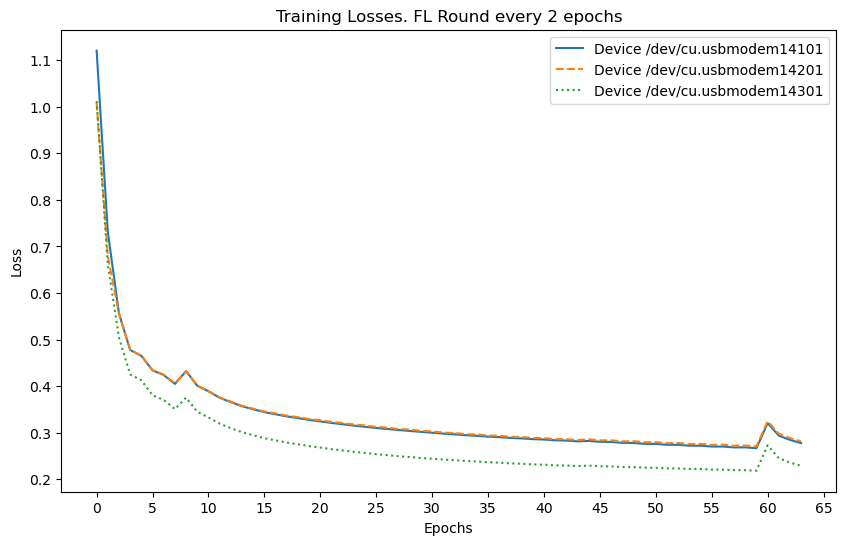

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']
# Enable interactive mode
plt.figure(figsize=(10,6))
for i,device in enumerate(all_losses_devices):
    linestyle = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(all_losses_devices[device], label=f"Device {device}", linestyle=linestyle)

fl_rounds = epochs // fl_every_epoch
epochs_per_fl_round = fl_every_epoch
total_epochs = fl_rounds * epochs_per_fl_round

# Add vertical lines to separate FL rounds
# for i in range(1, fl_rounds):
    # plt.axvline(i * epochs_per_fl_round, color='gray', linestyle='--')
# Customize the Locator object for y-axis ticks
y_locator = ticker.MultipleLocator(base=0.1)  # Adjust the base value as needed
plt.gca().yaxis.set_major_locator(y_locator)

plt.xticks(range(0,70,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses. FL Round every 2 epochs')
plt.legend()
plt.show()

In [29]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

#plt.figure(figsize=(10,6))
#for i,device in enumerate(all_devices_accuracies):
    #linestyle = line_styles[i % len(line_styles)]
    #marker = markers[i % len(markers)]
    #plt.plot(all_devices_accuracies[device], label=f"Device {device}", linestyle=linestyle)

#fl_rounds = epochs // fl_every_epoch
#epochs_per_fl_round = fl_every_epoch
#total_epochs = fl_rounds * epochs_per_fl_round

# Add vertical lines to separate FL rounds
#for i in range(1, fl_rounds):
    #plt.axvline(i * epochs_per_fl_round, color='gray', linestyle='--')

#y_locator = ticker.MultipleLocator(base=0.05)  # Adjust the base value as needed
#plt.gca().yaxis.set_major_locator(y_locator)
    
#plt.xticks(range(epochs))
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.title('Validation Set Accuracy. FL Round every 2 epochs')
#plt.legend()
#plt.show()

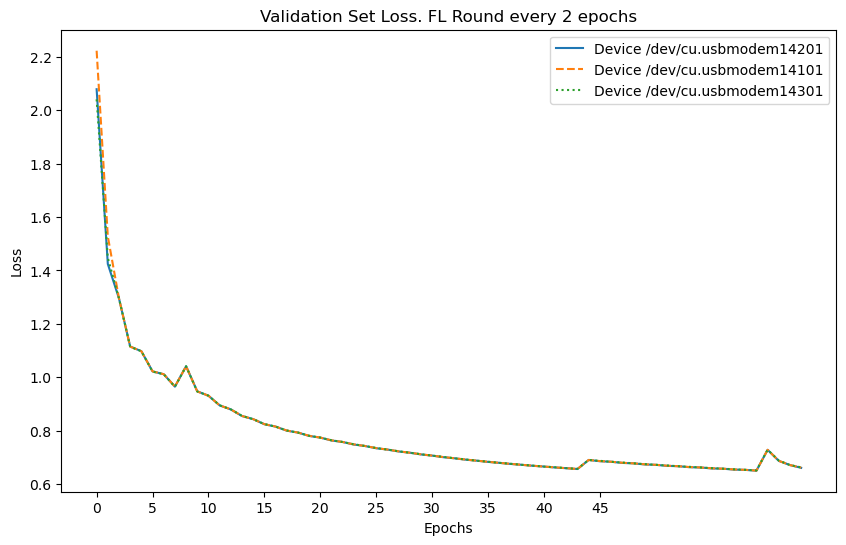

In [30]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
for i,device in enumerate(all_devices_valid_loss):
    linestyle = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(all_devices_valid_loss[device], label=f"Device {device}", linestyle=linestyle)

fl_rounds = epochs // fl_every_epoch
epochs_per_fl_round = fl_every_epoch
total_epochs = fl_rounds * epochs_per_fl_round

# Add vertical lines to separate FL rounds
#for i in range(1, fl_rounds):
    #plt.axvline(i * epochs_per_fl_round, color='gray', linestyle='--')
    
y_locator = ticker.MultipleLocator(base=0.2)  # Adjust the base value as needed
plt.gca().yaxis.set_major_locator(y_locator)
    
plt.xticks(range(0,50,5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Set Loss. FL Round every 2 epochs')
plt.legend()
plt.show()

In [636]:
sum(fl_info_infer[0]['infer_time']['/dev/cu.usbmodem114101']) / 1e9

0.511002

## Iris dataset

In [268]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=2)


### Keyword Spotting

In [270]:
import os
import json
# Keyword samples split
samples_folder = "./datasets/keywords_v3"
train_samples_split = 160 # Number of samples for training of each keyword
test_samples_split = 20   # Number of samples for training of each keyword
keywords_buttons = {
    "montserrat": 1,
    "pedraforca": 2,
    "vermell": 3,
    "blau": 4,
    #"verd": 5,
    # "up": 1,
    # "backward": 2,
    # "forward": 3,
    # "down": 4,
    # "left": 3,
    # "right": 4
}
def readKeyword(path_dir, keyword):
    with open(path_dir) as f:
        data = json.load(f)
        values = data['payload']['values']
        info = keyword.split('/')
        return info[0], values
import random
train_samples_split = 160 # Number of samples for training of each keyword
test_samples_split = 20   # Number of samples for training of each keyword

# Experiment sizes
training_epochs = 160   # Amount of training epochs. Can't be more than kws * train_samples_split
testing_epochs = 60     # Amount of test samples of each keyword. Can't be more than kws * test_samples_split

# Load the dataset
words = list(keywords_buttons.keys())
files = []
test_files = []
for i, word in enumerate(words):
    file_list = os.listdir(f"{samples_folder}/{word}")
    if (len(file_list) < train_samples_split + test_samples_split): 
        sys.exit(f"Not enough samples for keyword {word}")
    random.shuffle(file_list)
    files.append(list(map(lambda f: f"{word}/{f}", file_list[0:train_samples_split])))
    test_files.append(list(map(lambda f: f"{word}/{f}", file_list[train_samples_split:(train_samples_split+test_samples_split)])))

keywords = list(sum(zip(*files), ()))
test_keywords = list(sum(zip(*test_files), ()))

debug = True
if debug: print(f"Total available training keywords: {len(keywords)}")
if debug: print(f"Total available testing keywords: {len(test_keywords)}")
    
def get_x_y(data):
    ys = []
    xs = []
    train_names = []
    for keyword in data:
        info = keyword.split('/')
        train_names.append(info[0])

    train_names = set(train_names)
    test_names = []
    for keyword in test_keywords:
        info = keyword.split('/')
        test_names.append(info[0])

    test_names = set(test_names)
    name_to_int = {x:i for i,x in enumerate(test_names)}
    print(name_to_int)
    for keyword in data:
        name, values = readKeyword("./datasets/keywords_v3/" + keyword, keyword)
        ys.append(name_to_int[name])
        xs.append(values)
    return xs, ys

random.shuffle(keywords)
random.shuffle(test_keywords)
x_train, y_train = get_x_y(keywords)
x_test, y_test = get_x_y(test_keywords)

X_data = np.array(x_train).astype(np.float32)
X_data_test = np.array(x_test).astype(np.float32)
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 4)
Y_test = np_utils.to_categorical(y_test, 4)
X_train = np.array(x_train)
X_test = np.array(x_test)

Total available training keywords: 640
Total available testing keywords: 80
{'vermell': 0, 'pedraforca': 1, 'montserrat': 2, 'blau': 3}
{'vermell': 0, 'pedraforca': 1, 'montserrat': 2, 'blau': 3}


### Mnist dataset

In [114]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)

X_train.shape, Y_train.shape

Shape before one-hot encoding:  (60000,)


((60000, 28, 28), (60000, 10))

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

datos = pd.read_csv("creditcard.csv")
datos.drop(['Time'], axis=1, inplace=True)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

X_train, X_test = train_test_split(datos[:5000], test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values


In [18]:
X_train.shape, X_test.shape

((3998, 29), (1000, 29))

## Anomaly detection dataset

In [60]:
import pandas as pd
df = pd.read_csv("monitorData.csv")
df.head()

,Id,Type,QR,QS,QRU,QWRP,QWSP,RT,SSS,FMA,packetHeader/Type,packetHeader/Id,packetHeader/Size,packetHeader/Src,packetHeader/Dst,packetHeader/Via,packetHeader/SeqId,packetHeader/Num,src
0,0,0,0,0,0,0,0,1,11,120132,4,0,8,56988,65535,0,0,0,25516
1,0,0,0,0,0,0,0,0,12,120252,4,0,8,56988,65535,0,0,0,27980
2,0,0,0,0,0,0,0,1,12,120156,4,0,8,56988,65535,0,0,0,35872
3,0,0,0,0,0,0,0,1,17,112604,4,0,8,35872,65535,0,0,0,56988
4,1,0,0,0,0,0,0,2,18,119964,4,0,8,35872,65535,0,0,0,25516


In [61]:
from sklearn.preprocessing import MinMaxScaler

Is important to normalize data for faster converge and better performance during training.
the range of the input values is important due to the activation function used in our models, these functions are sensitive to the input values. When values are big the gradient of activation functions may become 0 or unstable depending on the activation function used. Normalizing the input values help preventing this problem.

In [62]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the dataset
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [64]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  354 non-null    float64
 1   Type                354 non-null    float64
 2   QR                  354 non-null    float64
 3   QS                  354 non-null    float64
 4   QRU                 354 non-null    float64
 5   QWRP                354 non-null    float64
 6   QWSP                354 non-null    float64
 7   RT                  354 non-null    float64
 8   SSS                 354 non-null    float64
 9   FMA                 354 non-null    float64
 10  packetHeader/Type   354 non-null    float64
 11  packetHeader/Id     354 non-null    float64
 12  packetHeader/Size   354 non-null    float64
 13  packetHeader/Src    354 non-null    float64
 14  packetHeader/Dst    354 non-null    float64
 15  packetHeader/Via    354 non-null    float64
 16  packetHe

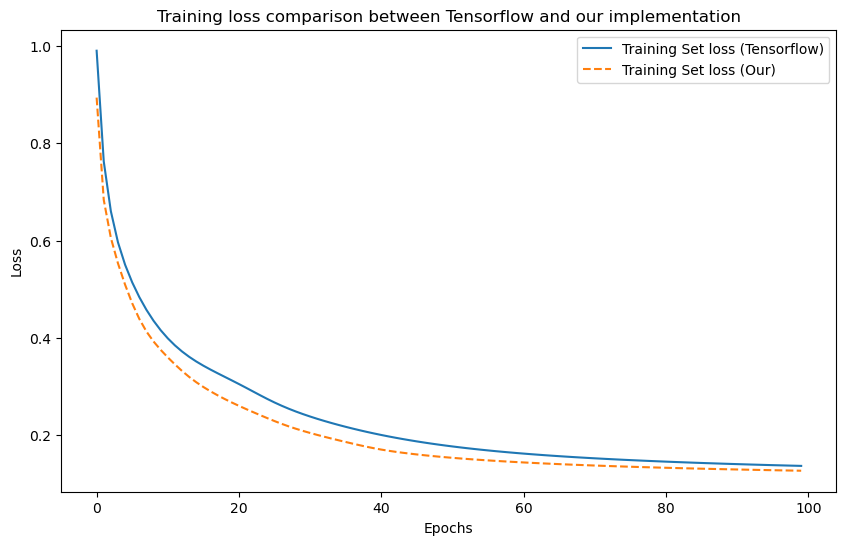

In [44]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

train_loss = [0.9903568029403687, 0.7628063559532166, 0.6603224873542786, 0.5963509678840637, 0.550324022769928, 0.5140912532806396, 0.48372766375541687, 0.45763322710990906, 0.4351411759853363, 0.4157593548297882, 0.39903658628463745, 0.38457220792770386, 0.37202438712120056, 0.36108335852622986, 0.35144245624542236, 0.3427945077419281, 0.3348226249217987, 0.32725995779037476, 0.3198816776275635, 0.31251803040504456, 0.30504801869392395, 0.29740968346595764, 0.28963565826416016, 0.281857430934906, 0.2743019461631775, 0.26714131236076355, 0.2604750096797943, 0.25429269671440125, 0.24856789410114288, 0.24325016140937805, 0.23828306794166565, 0.2335939258337021, 0.22916793823242188, 0.224958598613739, 0.2209472954273224, 0.2171127200126648, 0.2134474366903305, 0.20994344353675842, 0.20659245550632477, 0.20340318977832794, 0.2003507763147354, 0.19744479656219482, 0.19467945396900177, 0.19203835725784302, 0.18953904509544373, 0.18714188039302826, 0.1848699450492859, 0.18269936740398407, 0.18063409626483917, 0.17865969240665436, 0.1767892837524414, 0.1749924272298813, 0.17328234016895294, 0.17165791988372803, 0.1700926572084427, 0.16861282289028168, 0.16718128323554993, 0.16582681238651276, 0.16451911628246307, 0.16327576339244843, 0.16207481920719147, 0.16092516481876373, 0.1598297357559204, 0.15876491367816925, 0.1577521711587906, 0.15677116811275482, 0.1558302342891693, 0.15491488575935364, 0.15404149889945984, 0.15319731831550598, 0.1523822546005249, 0.15159259736537933, 0.15083417296409607, 0.15009735524654388, 0.14938101172447205, 0.1487015038728714, 0.14803771674633026, 0.14738653600215912, 0.14675238728523254, 0.14614391326904297, 0.14553961157798767, 0.14497508108615875, 0.14441892504692078, 0.14387443661689758, 0.14333480596542358, 0.14282144606113434, 0.1423216015100479, 0.14184080064296722, 0.14135263860225677, 0.1408940702676773, 0.1404464989900589, 0.14000220596790314, 0.13956093788146973, 0.13914571702480316, 0.13872972130775452, 0.13832083344459534, 0.1379481852054596, 0.1375560760498047, 0.13718537986278534, 0.13681328296661377]
train_loss_our = [0.893958, 0.683724, 0.605558, 0.553129, 0.509275, 0.471062, 0.438919, 0.413044, 0.392509, 0.375337, 0.359901, 0.345466, 0.331999, 0.319757, 0.308808, 0.299001, 0.290106, 0.281923, 0.274283, 0.267073, 0.260225, 0.253653, 0.247280, 0.241026, 0.234877, 0.228911, 0.223255, 0.218007, 0.213176, 0.208691, 0.204488, 0.200503, 0.196695, 0.193021, 0.189441, 0.185942, 0.182499, 0.179155, 0.175961, 0.173004, 0.170329, 0.167937, 0.165786, 0.163820, 0.162014, 0.160333, 0.158767, 0.157299, 0.155914, 0.154615, 0.153381, 0.152213, 0.151102, 0.150049, 0.149047, 0.148089, 0.147174, 0.146299, 0.145461, 0.144657, 0.143888, 0.143148, 0.142425, 0.141737, 0.141072, 0.140432, 0.139814, 0.139217, 0.138639, 0.138078, 0.137537, 0.137013, 0.136504, 0.136011, 0.135532, 0.135067, 0.134615, 0.134178, 0.133751, 0.133336, 0.132931, 0.132538, 0.132156, 0.131783, 0.131419, 0.131064, 0.130717, 0.130380, 0.130051, 0.129729, 0.129414, 0.129108, 0.128806, 0.128512, 0.128224, 0.127943, 0.127667, 0.127397, 0.127133, 0.126875]

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(train_loss, label=f"Training Set loss (Tensorflow)", linestyle=line_styles[0])
plt.plot(train_loss_our, label=f"Training Set loss (Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss comparison between Tensorflow and our implementation')
plt.legend()
plt.show()

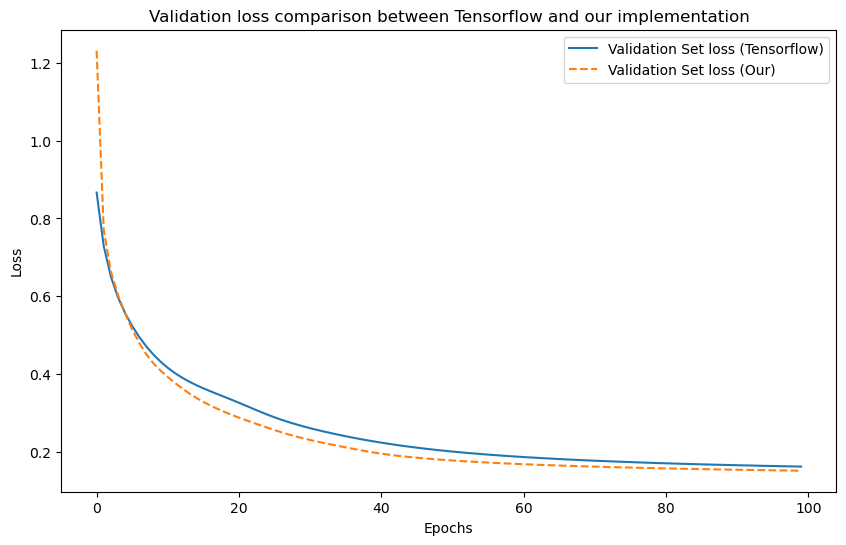

In [45]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']


val_loss = [0.8664199113845825, 0.7288760542869568, 0.6508371829986572, 0.5974512100219727, 0.556911051273346, 0.5237330794334412, 0.4954395592212677, 0.47106876969337463, 0.4500870406627655, 0.43202877044677734, 0.4164634644985199, 0.40300053358078003, 0.39133524894714355, 0.38114428520202637, 0.37211424112319946, 0.3639167249202728, 0.3562548756599426, 0.3488837778568268, 0.34160271286964417, 0.33426427841186523, 0.3267759382724762, 0.31909939646720886, 0.3113444447517395, 0.3036612868309021, 0.2963052988052368, 0.2894035279750824, 0.2829681932926178, 0.27703648805618286, 0.27154436707496643, 0.2664000391960144, 0.2615760564804077, 0.2570231556892395, 0.25272515416145325, 0.248594269156456, 0.24466411769390106, 0.24088312685489655, 0.23728574812412262, 0.23381318151950836, 0.23052582144737244, 0.22738462686538696, 0.22441959381103516, 0.22156354784965515, 0.21886996924877167, 0.21626898646354675, 0.21381914615631104, 0.21151606738567352, 0.20929396152496338, 0.20719914138317108, 0.20520275831222534, 0.20331917703151703, 0.20152054727077484, 0.19979587197303772, 0.19813001155853271, 0.19661632180213928, 0.19516155123710632, 0.19371406733989716, 0.19243638217449188, 0.19103577733039856, 0.18980772793293, 0.1886083036661148, 0.18745942413806915, 0.18637330830097198, 0.185330331325531, 0.18426814675331116, 0.18330702185630798, 0.18231301009655, 0.1814034879207611, 0.1804947853088379, 0.17965732514858246, 0.1788540780544281, 0.17804144322872162, 0.17727400362491608, 0.17661501467227936, 0.17586462199687958, 0.17517629265785217, 0.17448416352272034, 0.1738056093454361, 0.17322824895381927, 0.17256750166416168, 0.17193308472633362, 0.1714223474264145, 0.17081686854362488, 0.17029894888401031, 0.16980122029781342, 0.16923782229423523, 0.16870012879371643, 0.168229877948761, 0.16781441867351532, 0.1673336625099182, 0.16689909994602203, 0.1664421707391739, 0.16597846150398254, 0.16572275757789612, 0.16519030928611755, 0.16478584706783295, 0.1645079255104065, 0.16401246190071106, 0.16366077959537506, 0.16331592202186584, 0.1629415601491928]
val_loss_our = [1.230570, 0.770017, 0.663738, 0.603166, 0.556088, 0.515023, 0.479747, 0.450722, 0.427717, 0.409084, 0.392869, 0.377904, 0.363857, 0.350932, 0.339320, 0.328948, 0.319607, 0.311063, 0.303142, 0.295692, 0.288628, 0.281900, 0.275419, 0.269094, 0.262863, 0.256750, 0.250878, 0.245384, 0.240321, 0.235646, 0.231285, 0.227174, 0.223255, 0.219488, 0.215837, 0.212267, 0.208766, 0.205342, 0.202038, 0.198941, 0.196126, 0.193611, 0.191365, 0.189333, 0.187470, 0.185748, 0.184144, 0.182637, 0.181223, 0.179896, 0.178640, 0.177456, 0.176331, 0.175262, 0.174248, 0.173281, 0.172360, 0.171484, 0.170645, 0.169845, 0.169077, 0.168344, 0.167641, 0.166954, 0.166302, 0.165669, 0.165060, 0.164471, 0.163900, 0.163348, 0.162812, 0.162292, 0.161789, 0.161301, 0.160828, 0.160371, 0.159926, 0.159497, 0.159081, 0.158676, 0.158281, 0.157899, 0.157526, 0.157161, 0.156807, 0.156461, 0.156123, 0.155793, 0.155470, 0.155155, 0.154847, 0.154546, 0.154250, 0.153962, 0.153679, 0.153400, 0.153128, 0.152861, 0.152600, 0.152343]

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(val_loss, label=f"Validation Set loss (Tensorflow)", linestyle=line_styles[0])
plt.plot(val_loss_our, label=f"Validation Set loss (Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss comparison between Tensorflow and our implementation')
plt.legend()
plt.show()

In [ ]:
cnn_valid_tf = [0.21848034858703613, 0.1437973529100418, 0.11280103772878647, 0.09034352749586105, 0.08687180280685425, 0.07897087931632996, 0.07881997525691986, 0.07366442680358887, 0.06859507411718369, 0.06733980774879456, 0.06398254632949829, 0.0691317468881607, 0.06345953047275543, 0.057599250227212906, 0.05789942666888237, 0.06646180152893066, 0.05904307961463928, 0.06256557255983353, 0.05541553348302841, 0.055995527654886246, 0.05669771134853363, 0.05645587667822838, 0.05414196848869324, 0.05653410777449608, 0.053415361791849136, 0.05904849246144295, 0.05773834139108658, 0.05499989539384842, 0.05554388463497162, 0.059184808284044266, 0.056101758033037186, 0.05850554630160332, 0.0582786425948143, 0.059940729290246964, 0.050419602543115616, 0.05906102806329727, 0.05324019119143486, 0.05527801066637039, 0.05684319883584976, 0.053868163377046585, 0.056612927466630936, 0.0548669807612896, 0.059645410627126694, 0.05139223486185074, 0.055304497480392456, 0.06023583933711052, 0.05260230228304863, 0.05323423445224762, 0.053582411259412766, 0.05505114793777466, 0.057623621076345444, 0.056282252073287964, 0.055649980902671814, 0.052225787192583084, 0.056390974670648575, 0.054085083305835724, 0.05834873020648956, 0.05673611909151077, 0.05578933283686638, 0.058263421058654785, 0.05259609967470169, 0.05622631683945656, 0.0611502006649971, 0.05533025413751602, 0.055094584822654724, 0.05577748268842697, 0.05515044555068016, 0.05506435036659241, 0.055146776139736176, 0.0552290603518486, 0.056463390588760376, 0.05673900246620178, 0.0576544813811779, 0.0571356937289238, 0.05770120397210121, 0.0572972297668457, 0.056707341223955154, 0.05788480117917061, 0.05768539384007454, 0.056215234100818634, 0.060948193073272705, 0.057697843760252, 0.058830976486206055, 0.05939805135130882, 0.060082897543907166, 0.056624121963977814, 0.05785224586725235, 0.05685444176197052, 0.05836649239063263, 0.05785844102501869, 0.05795498192310333, 0.05758903920650482, 0.05981667339801788, 0.058029308915138245, 0.05793704837560654, 0.059250205755233765, 0.058112792670726776, 0.05828135833144188, 0.058318842202425, 0.056488603353500366]
cnn_train_tf = [0.5915535092353821, 0.17271727323532104, 0.12857839465141296, 0.10503339767456055, 0.09315040707588196, 0.08412138372659683, 0.079491525888443, 0.07169309258460999, 0.06716097146272659, 0.06433694064617157, 0.06042487919330597, 0.05717138200998306, 0.05581904575228691, 0.05405057594180107, 0.04923480749130249, 0.04874063655734062, 0.04535014554858208, 0.04412306472659111, 0.04302501678466797, 0.04276011511683464, 0.03922915831208229, 0.036927442997694016, 0.035117119550704956, 0.03367925435304642, 0.032168198376894, 0.03218202665448189, 0.03277328982949257, 0.03391849622130394, 0.02940519154071808, 0.028941581025719643, 0.027746591717004776, 0.02688169851899147, 0.02690940909087658, 0.026401318609714508, 0.025742633268237114, 0.023516563698649406, 0.02344449795782566, 0.023209810256958008, 0.02269790694117546, 0.022717077285051346, 0.019658228382468224, 0.019382383674383163, 0.01932947337627411, 0.019247673451900482, 0.01811133697628975, 0.017265425994992256, 0.019570453092455864, 0.016566647216677666, 0.015622514300048351, 0.01574467308819294, 0.014531685039401054, 0.01552104763686657, 0.014788857661187649, 0.014537392184138298, 0.013846919871866703, 0.013058184646070004, 0.011966410093009472, 0.012344352900981903, 0.011498955078423023, 0.0108367083594203, 0.010798418894410133, 0.010992597788572311, 0.013778474181890488, 0.012088503688573837, 0.010204910300672054, 0.009804636240005493, 0.009154542349278927, 0.008909089490771294, 0.009249554015696049, 0.008859405294060707, 0.007896809838712215, 0.007621555123478174, 0.007611350622028112, 0.009001288563013077, 0.008342684246599674, 0.007554497104138136, 0.007459802553057671, 0.007079777307808399, 0.006805106066167355, 0.006531857885420322, 0.006493932101875544, 0.005914083682000637, 0.005753582343459129, 0.005646183621138334, 0.005398968700319529, 0.005160376895219088, 0.005171061493456364, 0.005031037610024214, 0.004832217004150152, 0.004686493426561356, 0.0047033014707267284, 0.004325464367866516, 0.0043526035733520985, 0.00417504133656621, 0.004075608681887388, 0.003889727173373103, 0.0038834011647850275, 0.004001007881015539, 0.003911340609192848, 0.0038985731080174446]

cnn_valid_acc = [0.9401000142097473, 0.9570000171661377, 0.9672999978065491, 0.9732000231742859, 0.9728999733924866, 0.9735999703407288, 0.9761000275611877, 0.9779999852180481, 0.9789000153541565, 0.9794999957084656, 0.9790999889373779, 0.9772999882698059, 0.9799000024795532, 0.9815000295639038, 0.9815000295639038, 0.978600025177002, 0.98089998960495, 0.9796000123023987, 0.9836000204086304, 0.9821000099182129, 0.9825000166893005, 0.9819999933242798, 0.9836000204086304, 0.9818000197410583, 0.9822999835014343, 0.982200026512146, 0.9815999865531921, 0.9812999963760376, 0.9817000031471252, 0.98089998960495, 0.9836000204086304, 0.982200026512146, 0.9824000000953674, 0.9807999730110168, 0.9825999736785889, 0.9811000227928162, 0.9829999804496765, 0.9836000204086304, 0.9821000099182129, 0.9817000031471252, 0.9812999963760376, 0.982699990272522, 0.98089998960495, 0.983299970626831, 0.982699990272522, 0.9803000092506409, 0.9829999804496765, 0.9839000105857849, 0.982699990272522, 0.9825000166893005, 0.9818999767303467, 0.9807999730110168, 0.9828000068664551, 0.982699990272522, 0.9814000129699707, 0.9825999736785889, 0.9815000295639038, 0.9824000000953674, 0.9818000197410583, 0.9817000031471252, 0.9842000007629395, 0.982699990272522, 0.9810000061988831, 0.9828000068664551, 0.9836000204086304, 0.9835000038146973, 0.9836999773979187, 0.984000027179718, 0.9824000000953674, 0.9828000068664551, 0.9828000068664551, 0.9822999835014343, 0.9825999736785889, 0.983299970626831, 0.984499990940094, 0.9836000204086304, 0.9836000204086304, 0.983299970626831, 0.9829999804496765, 0.982699990272522, 0.982699990272522, 0.9825000166893005, 0.982699990272522, 0.9818999767303467, 0.9822999835014343, 0.983299970626831, 0.9824000000953674, 0.9824000000953674, 0.982699990272522, 0.9832000136375427, 0.9833999872207642, 0.9822999835014343, 0.9825000166893005, 0.982200026512146, 0.9824000000953674, 0.9828000068664551, 0.9829000234603882, 0.9829999804496765, 0.9828000068664551, 0.9828000068664551]
cnn_train_acc = [0.8519666790962219, 0.95128333568573, 0.9625666737556458, 0.9691166877746582, 0.9722499847412109, 0.9757999777793884, 0.9763500094413757, 0.9785000085830688, 0.9801666736602783, 0.9803666472434998, 0.9819833040237427, 0.982616662979126, 0.982866644859314, 0.9838333129882812, 0.9853500127792358, 0.9852166771888733, 0.9865166544914246, 0.9865999817848206, 0.9872666597366333, 0.9870666861534119, 0.9883166551589966, 0.9889000058174133, 0.989883303642273, 0.9898499846458435, 0.9908666610717773, 0.9906833171844482, 0.9900500178337097, 0.9897333383560181, 0.9913666844367981, 0.9911500215530396, 0.9918500185012817, 0.9925500154495239, 0.9922500252723694, 0.9926166534423828, 0.9922833442687988, 0.9933833479881287, 0.9934499859809875, 0.9932833313941956, 0.9939166903495789, 0.9935833215713501, 0.9950166940689087, 0.9947333335876465, 0.9944333434104919, 0.9948999881744385, 0.9952666759490967, 0.9955666661262512, 0.9944000244140625, 0.9958833456039429, 0.9961333274841309, 0.996066689491272, 0.996666669845581, 0.9960833191871643, 0.996566653251648, 0.9964666962623596, 0.9968500137329102, 0.9970333576202393, 0.9974499940872192, 0.9971666932106018, 0.9975000023841858, 0.9977166652679443, 0.9977166652679443, 0.9978166818618774, 0.9965833425521851, 0.9970999956130981, 0.998116672039032, 0.9981499910354614, 0.9986166954040527, 0.998533308506012, 0.9982500076293945, 0.9985666871070862, 0.9990000128746033, 0.9991333484649658, 0.9989833235740662, 0.9984333515167236, 0.9985833168029785, 0.9990333318710327, 0.9988499879837036, 0.9989666938781738, 0.9990333318710327, 0.9993333220481873, 0.9993166923522949, 0.9994166493415833, 0.9994000196456909, 0.9994666576385498, 0.9995333552360535, 0.9995833039283752, 0.9995499849319458, 0.9995333552360535, 0.9995833039283752, 0.999666690826416, 0.9997166395187378, 0.9998000264167786, 0.9996833205223083, 0.9997666478157043, 0.999833345413208, 0.9998000264167786, 0.9998166561126709, 0.9998000264167786, 0.9997833371162415, 0.999833345413208]

In [56]:
# TENSORFLOW

loss = [1.959566593170166, 1.227865219116211, 0.8419866561889648, 0.638801634311676, 0.5150259137153625, 0.4311065375804901, 0.37486109137535095, 0.3352672755718231, 0.304882675409317, 0.2817482054233551, 0.26331955194473267, 0.24746952950954437, 0.23516309261322021, 0.22400596737861633, 0.21401162445545197, 0.205986887216568, 0.19834379851818085, 0.19154666364192963, 0.1854851245880127, 0.18004532158374786, 0.17504964768886566, 0.1708144098520279, 0.16683049499988556, 0.16242073476314545, 0.15867090225219727]
val_loss = [1.5231969356536865, 0.984671413898468, 0.7122002840042114, 0.5565064549446106, 0.4570382833480835, 0.38568931818008423, 0.33854204416275024, 0.3068647086620331, 0.28120529651641846, 0.2608382999897003, 0.24407897889614105, 0.23009982705116272, 0.22249464690685272, 0.20964328944683075, 0.2000943124294281, 0.19414077699184418, 0.18749675154685974, 0.18052147328853607, 0.17919358611106873, 0.17418721318244934, 0.16909334063529968, 0.1646670550107956, 0.16063827276229858, 0.1572045236825943, 0.15271161496639252]
acc = [0.46753332018852234, 0.7347999811172485, 0.8258833289146423, 0.862416684627533, 0.884066641330719, 0.8995166420936584, 0.9095333218574524, 0.9171666502952576, 0.923466682434082, 0.9282833337783813, 0.9318333268165588, 0.9362333416938782, 0.9379833340644836, 0.941016674041748, 0.9429833292961121, 0.9452999830245972, 0.9469333291053772, 0.9483833312988281, 0.9497500061988831, 0.9516333341598511, 0.9527333378791809, 0.9531499743461609, 0.9542166590690613, 0.9559999704360962, 0.956250011920929]
val_acc = [0.6567000150680542, 0.8055999875068665, 0.855400025844574, 0.8838000297546387, 0.900600016117096, 0.9108999967575073, 0.9204999804496765, 0.9264000058174133, 0.9301000237464905, 0.9319000244140625, 0.9369000196456909, 0.9399999976158142, 0.9419000148773193, 0.944599986076355, 0.946399986743927, 0.9472000002861023, 0.9506999850273132, 0.9506000280380249, 0.9501000046730042, 0.95169997215271, 0.9524999856948853, 0.9539999961853027, 0.9553999900817871, 0.95660001039505, 0.9578999876976013]


# OUR

val_acc_our = [0.842400, 0.893000, 0.907300, 0.917600, 0.927900, 0.932000, 0.936700, 0.941500, 0.942100, 0.946400, 0.947000, 0.951800, 0.952200, 0.951800, 0.953900, 0.953000, 0.955600, 0.954400, 0.953300, 0.958500, 0.958600, 0.958900, 0.958900, 0.958800, 0.960600]
val_loss_our = [0.575744,0.400884,0.341084,0.307212,0.264596,0.257206,0.227454,0.216053,0.211022,0.195401,0.190579,0.179105,0.174914,0.176110,0.170826,0.166402,0.163560,0.164187,0.163799,0.152433,0.146564,0.142888,0.142839,0.143701,0.139428]

acc_our = [0.698150, 0.859900, 0.896233, 0.910050, 0.916933, 0.922400, 0.928450, 0.934583, 0.938067, 0.940767, 0.944167, 0.946517, 0.949050, 0.948867, 0.948167, 0.950617, 0.952033, 0.953200, 0.952500, 0.955883, 0.956167, 0.957017, 0.957533, 0.957083, 0.957633]
loss_our = [0.987681, 0.498099, 0.380210, 0.327054, 0.303201, 0.282063, 0.257978, 0.239724, 0.224569, 0.214351, 0.202987, 0.193813, 0.186628, 0.182487, 0.184277, 0.178243, 0.169962, 0.166654, 0.167948, 0.158082, 0.154703, 0.150368, 0.149334, 0.149072, 0.148101]

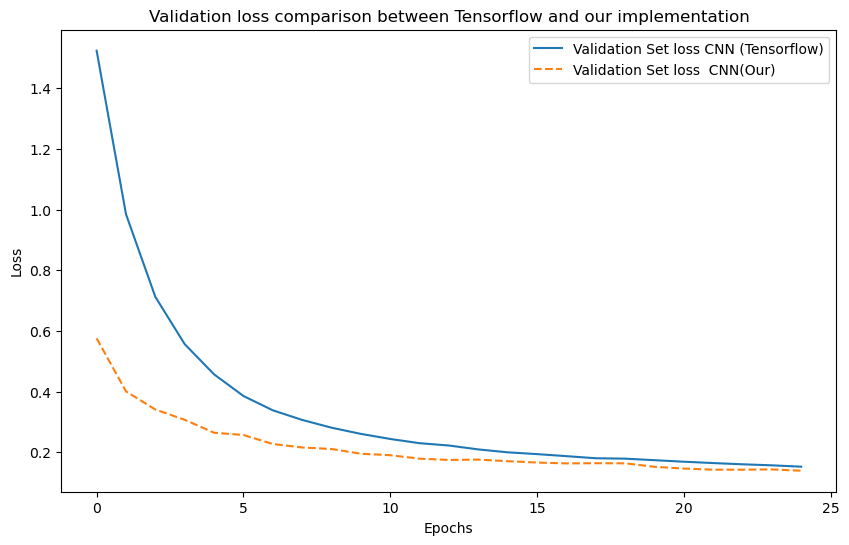

In [57]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(val_loss, label=f"Validation Set loss CNN (Tensorflow)", linestyle=line_styles[0])
plt.plot(val_loss_our, label=f"Validation Set loss  CNN(Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss comparison between Tensorflow and our implementation')
plt.legend()
plt.show()

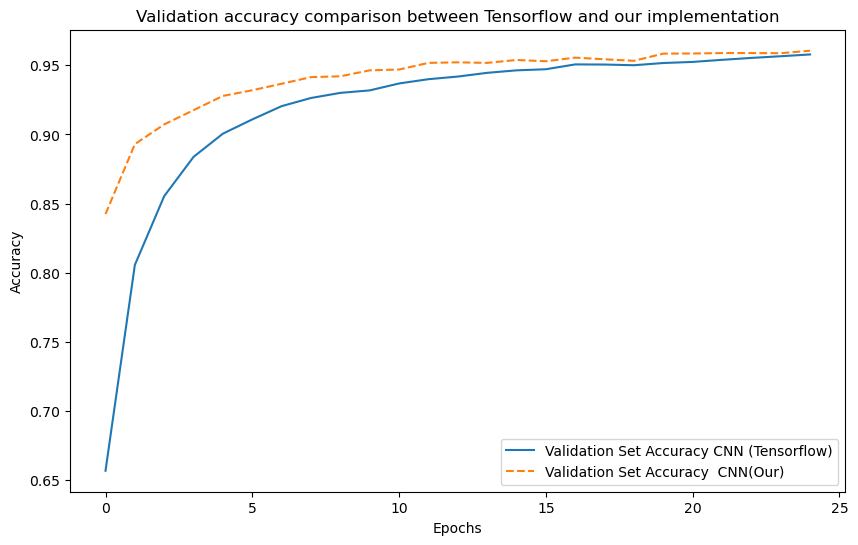

In [58]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(val_acc, label=f"Validation Set Accuracy CNN (Tensorflow)", linestyle=line_styles[0])
plt.plot(val_acc_our, label=f"Validation Set Accuracy  CNN(Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracy comparison between Tensorflow and our implementation')
plt.legend()
plt.show()